In [ ]:
import pandas as pd
from sodapy import Socrata

/Users/jeonseo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Reference: Overall CO2 Emission Trends in Globe

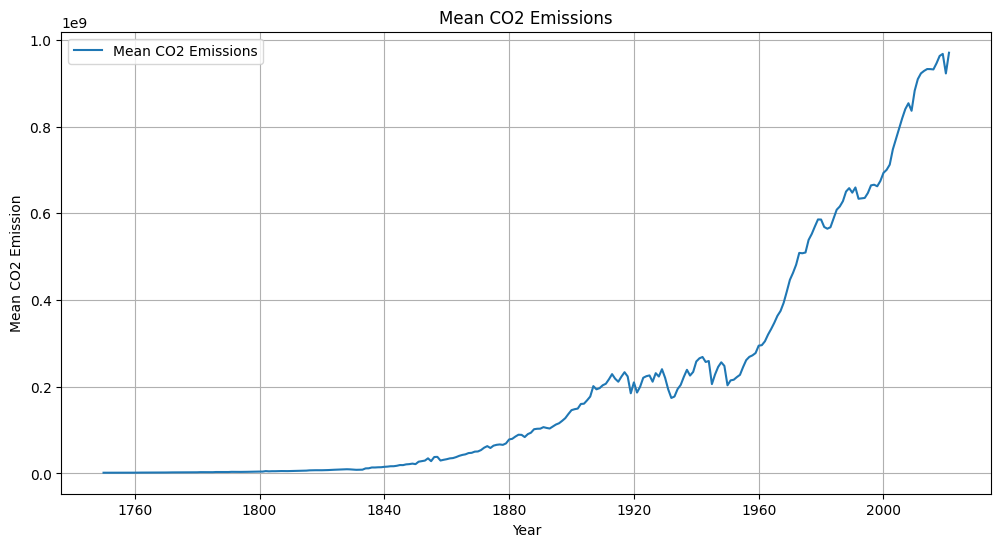

In [ ]:
Reference = pd.read_csv("annual-co2-emissions-per-country.csv")
Reference.head()


Reference['Year'] = pd.to_datetime(Reference['Year'], format='%Y')

mean_co2_emissions = Reference.groupby("Year")['Annual CO₂ emissions'].mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(mean_co2_emissions.index, mean_co2_emissions.values, label='Mean CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('Mean CO2 Emission')
plt.title('Mean CO2 Emissions')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 


In [ ]:
client = Socrata("data.cityofnewyork.us", None)
results = client.get("7x5e-2fxh", limit=2000)
results_df = pd.DataFrame.from_records(results)
results_df.head()
results_df.shape

(2000, 249)

### Data Preprocessing

In [ ]:
# Convert Object to Numeric Values
text_numeric_columns = results_df.select_dtypes(include=['object']).columns
text_numeric_columns

for col in text_numeric_columns:
    results_df[col] = pd.to_numeric(results_df[col], errors='coerce')
    
    

In [ ]:
# Use dropna() with the thresh parameter to drop columns

threshold = len(results_df) * 0.9
df_cleaned = results_df.dropna(axis=1, thresh=threshold)
df_cleaned.shape[1]

df_cleaned.head()

,property_id,postal_code,largest_property_use_type_1,year_built,number_of_buildings,occupancy,national_median_energy_star,site_eui_kbtu_ft,weather_normalized_site_eui,national_median_site_eui,...,property_gfa_calculated_1,number_of_active_energy_meters,number_of_active_energy_meters_1,number_of_active_energy_meters_2,number_of_active_it_meters,latitude,longitude,community_board,council_district,census_tract
0,21205224,11103.0,25000.0,2010,1,100,50,66.7,70.4,76.1,...,25000.0,8,8,0,0,40.769272,-73.913633,401.0,22.0,6502.0
1,2665352,10025.0,260780.0,1970,1,100,50,19.2,19.2,45.5,...,261980.0,6,6,0,0,40.790503,-73.967920,107.0,6.0,177.0
2,2665400,10025.0,324378.0,1943,1,100,50,66.9,72.0,87.1,...,333342.0,3,3,0,0,40.792758,-73.965171,107.0,7.0,181.0
3,2665405,10013.0,1039841.0,1975,3,100,50,113.8,121.1,70.5,...,1112900.0,4,4,0,0,NaN,NaN,NaN,NaN,NaN
4,2665415,10031.0,72662.0,1941,1,100,50,114.6,NaN,96.0,...,72662.0,11,11,0,0,40.823008,-73.950670,109.0,7.0,225.0


In [ ]:
# Cleaning: Inf or NaN Values

inf_columns = np.isinf(df_cleaned).any()
count_true = inf_columns.sum()
count_true


# Check for missing values (NaN)
nan_columns = np.isnan(df_cleaned).any()
count_true = nan_columns.sum()
count_true 

# Columns still having NaN
columns_with_nan = df_cleaned.columns[df_cleaned.isna().any()]

df_cleaned.fillna(df_cleaned.median(), inplace=True)

df_cleaned.isna().sum()


/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_35091/1378519480.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.fillna(df_cleaned.median(), inplace=True)


property_id                         0
postal_code                         0
largest_property_use_type_1         0
year_built                          0
number_of_buildings                 0
occupancy                           0
national_median_energy_star         0
site_eui_kbtu_ft                    0
weather_normalized_site_eui         0
national_median_site_eui            0
site_energy_use_kbtu                0
weather_normalized_site_energy      0
weather_normalized_site             0
source_eui_kbtu_ft                  0
weather_normalized_source           0
national_median_source_eui          0
source_energy_use_kbtu              0
weather_normalized_source_1         0
natural_gas_use_kbtu                0
natural_gas_use_therms              0
electricity_use_grid_purchase       0
electricity_use_grid_purchase_1     0
weather_normalized_site_3           0
electricity_use_grid_purchase_2     0
electricity_use_grid_purchase_3     0
green_power_offsite_kwh             0
green_power_

### Traditional Statistical Model

In [ ]:
selected_columns = ['number_of_buildings', 'year_built', 'occupancy', 'property_gfa_self_reported', 'weather_normalized_site', 
                    'site_energy_use_kbtu', 'net_emissions_metric_tons']

df_cleaned = df_cleaned[selected_columns]

df_cleaned.head()

new_column_names = {
    'number_of_buildings': 'Numer of Buildings',
    'year_built': 'Year Built',
    "occupancy": "Occupancy",
    'property_gfa_self_reported': 'Property Gross Floor Area', 
    'weather_normalized_site': 'Weather Normalized Site (EUI)', 
    'site_energy_use_kbtu': 'Site Energy Use (Kbtu)', 
    'net_emissions_metric_tons': 'Net Carbon Emissions (Metric tons)'
}

# Rename columns using the rename method
df_cleaned.rename(columns = new_column_names, inplace=True)

df_cleaned.head()

X = df_cleaned.loc[:, df_cleaned.columns != 'Net Carbon Emissions (Metric tons)']

y = df_cleaned['Net Carbon Emissions (Metric tons)'] 

# Add a constant column for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = sm.OLS(y_train, X_train)

# Fit the model to the training data
results = model.fit()

# Print the summary statistics, including p-values
print(results.summary())


                                    OLS Regression Results                                    
Dep. Variable:     Net Carbon Emissions (Metric tons)   R-squared:                       0.981
Model:                                            OLS   Adj. R-squared:                  0.981
Method:                                 Least Squares   F-statistic:                 1.391e+04
Date:                                Sun, 08 Oct 2023   Prob (F-statistic):               0.00
Time:                                        04:09:39   Log-Likelihood:                -10359.
No. Observations:                                1600   AIC:                         2.073e+04
Df Residuals:                                    1593   BIC:                         2.077e+04
Df Model:                                           6                                         
Covariance Type:                            nonrobust                                         
                                    coef    std er

### Sort by p-value 

In [ ]:
coefficients = results.params
p_values = results.pvalues
conf_int = results.conf_int()

# Step 3: Rank Variables by p-values (Statistical Significance)
# Create a DataFrame to store variable statistics
variable_stats = pd.DataFrame({'Coefficient': coefficients, 'P-value': p_values})

# Sort variables by ascending p-values
sorted_stats = variable_stats.sort_values(by='P-value')

# Step 4: Select a Subset of Variables
# You can choose to keep variables with a specific significance threshold (e.g., p < 0.05)
significant_variables = sorted_stats[sorted_stats['P-value'] < 0.05]

print(sorted_stats[:20])


                               Coefficient       P-value
Site Energy Use (Kbtu)            0.000056  0.000000e+00
Property Gross Floor Area         0.000898  3.154983e-80
Weather Normalized Site (EUI)     2.998623  2.197510e-13
Occupancy                        -0.927769  2.060850e-02
Numer of Buildings               -1.513992  9.313782e-02
const                           120.609746  6.210708e-01
Year Built                       -0.037836  7.574536e-01


### Regression Plot of Each Independent Variable vs. Carbon Emission

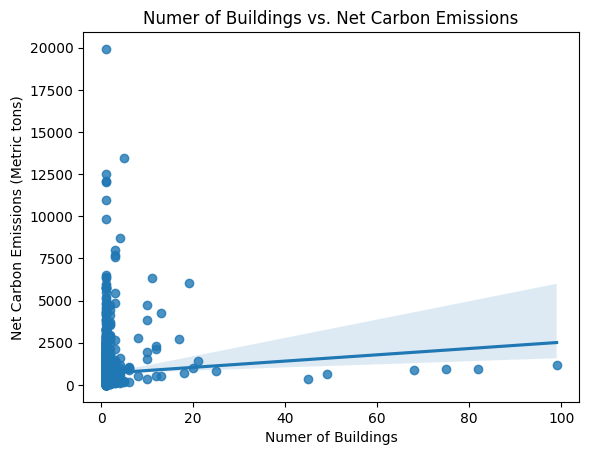

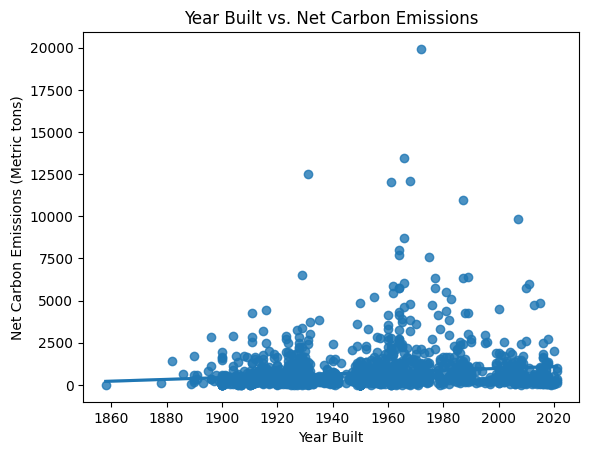

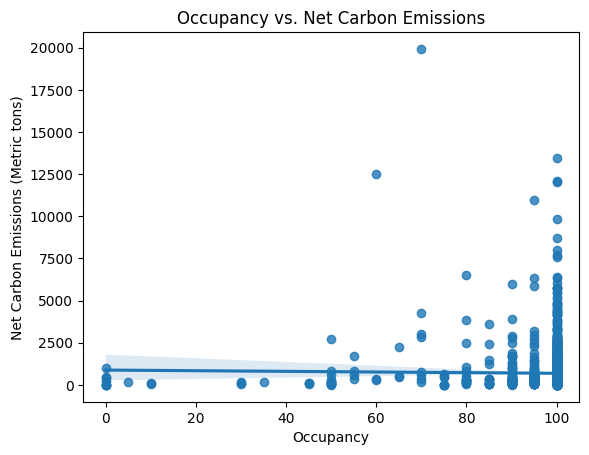

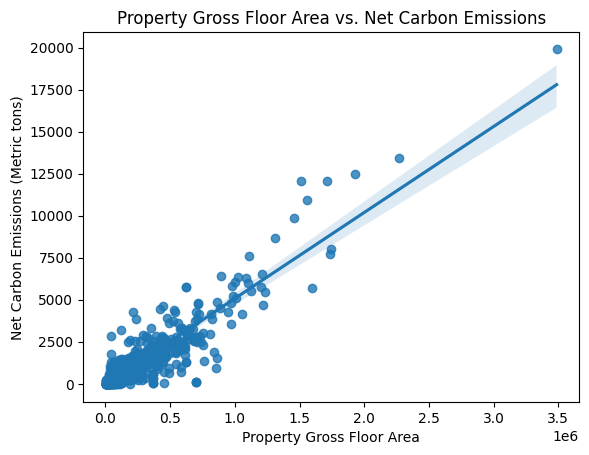

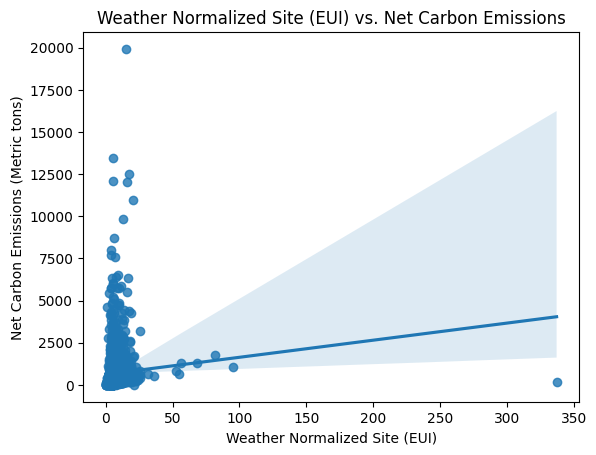

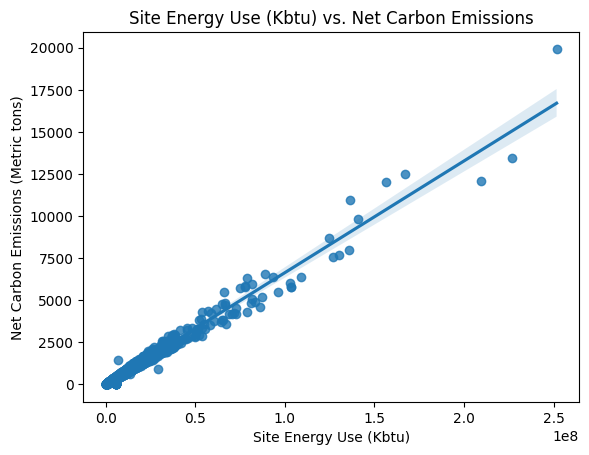

In [ ]:
for column in df_cleaned.columns:
    if column != 'Net Carbon Emissions (Metric tons)':
        sns.regplot(data=df_cleaned, x=column, y='Net Carbon Emissions (Metric tons)')
        plt.title(f'{column} vs. Net Carbon Emissions')
        plt.show()

### Correlation between Independent Variables 


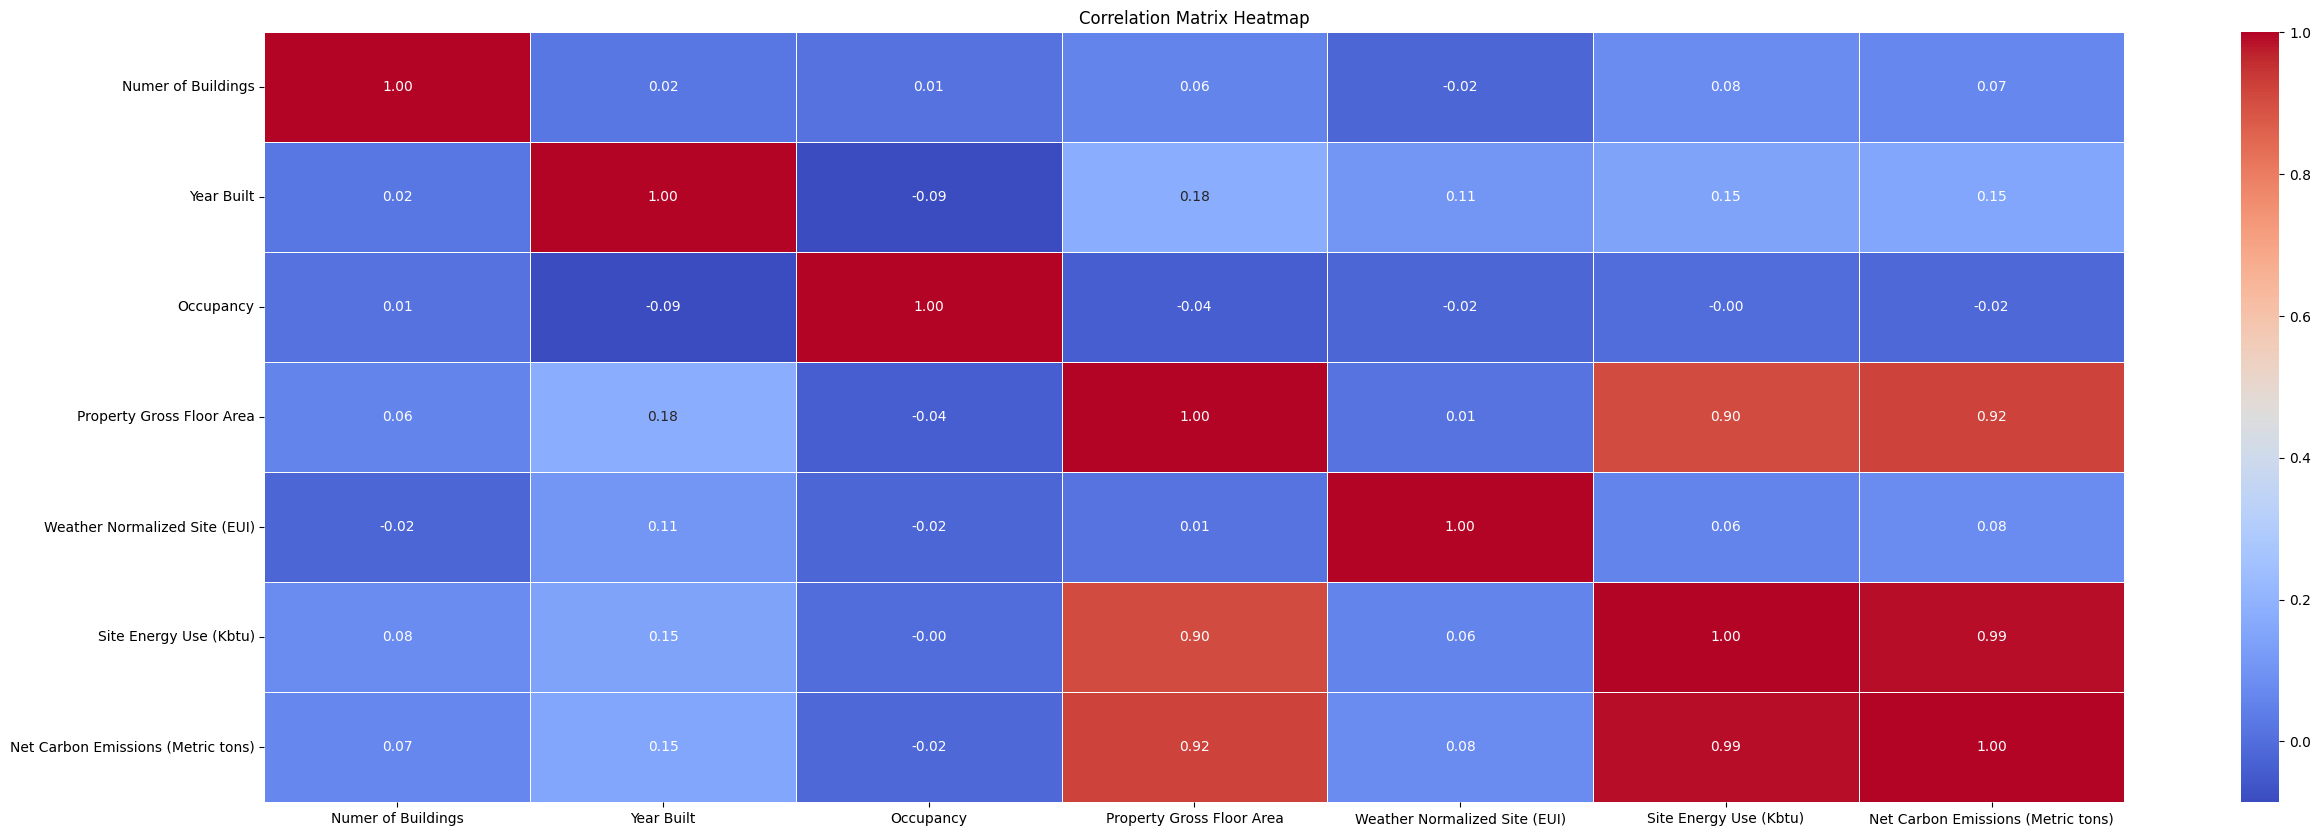

In [ ]:
corr_matrix = df_cleaned.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(30, 10))  # Set the figure size (adjust as needed)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Set the plot title
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

#### ML Model 1) KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler 
from sklearn import preprocessing


X = df_cleaned.drop(columns=['Net Carbon Emissions (Metric tons)'])
   
y = df_cleaned['Net Carbon Emissions (Metric tons)'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = preprocessing.StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
knn_train_score = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
knn_train_score = (-knn_train_score).mean()

knn_test_score = cross_val_score(knn, X_test_scaled, y_test, cv=5, scoring='neg_mean_squared_error')
knn_test_score = (-knn_test_score).mean()


print(f"Training Set'S MSE: {knn_train_score}")
print(f"Test Set'S MSE: {knn_test_score}")


print("Training-set score: {:.3f}".format(knn.score(X_train_scaled, y_train)))
print("Test-set score: {:.3f}".format(knn.score(X_test_scaled, y_test)))


Training Set'S MSE: 103138.29061525
Test Set'S MSE: 418225.091404
Training-set score: 0.949
Test-set score: 0.942


### ML Model 2) Linear Regression Model 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train_scaled, y_train)
OLS_train_score = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
OLS_train_score = (-OLS_train_score).mean()


OLS_test_score = cross_val_score(lr, X_test_scaled, y_test, cv=5, scoring='neg_mean_squared_error')
OLS_test_score = (-OLS_test_score).mean()


print(f"Training Set'S MSE: {OLS_train_score}")
print(f"Test Set'S MSE: {OLS_test_score}")

print("Training-set score: {:.3f}".format(lr.score(X_train_scaled, y_train)))
print("Test-set score: {:.3f}".format(lr.score(X_test_scaled, y_test)))

Training Set'S MSE: 32801.12761232202
Test Set'S MSE: 45497.975063494756
Training-set score: 0.981
Test-set score: 0.978


### ML Model 3) Lasso 

In [ ]:
from sklearn.linear_model import Lasso

lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train_scaled, y_train)
lasso001_train_score = cross_val_score(lasso001, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
lasso001_train_score = (-lasso001_train_score).mean()


lasso001_test_score = cross_val_score(lasso001, X_test_scaled, y_test, cv=5, scoring='neg_mean_squared_error')
lasso001_test_score = (-lasso001_test_score).mean()


print(f"Training Set'S MSE: {lasso001_train_score}")
print(f"Test Set'S MSE: {lasso001_test_score}")
print("Number of features used: {}".format(np.sum(lasso001.coef_ != 0)))

print("Training-set score: {:.3f}".format(lasso001.score(X_train_scaled, y_train)))
print("Test-set score: {:.3f}".format(lasso001.score(X_test_scaled, y_test)))


Training Set'S MSE: 32798.52653356789
Test Set'S MSE: 45485.813396932834
Number of features used: 6
Training-set score: 0.981
Test-set score: 0.978


### R^2

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = knn.predict(X_test_scaled)

# Calculate the R-squared score
r_squared = r2_score(y_test, y_pred)

print(f"R-squared (R²) Score: {r_squared:.2f}")


R-squared (R²) Score: 0.94


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = lr.predict(X_test_scaled)

# Calculate the R-squared score
r_squared = r2_score(y_test, y_pred)

print(f"R-squared (R²) Score: {r_squared:.2f}")


R-squared (R²) Score: 0.98


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = lasso001.predict(X_test_scaled)

# Calculate the R-squared score
r_squared = r2_score(y_test, y_pred)

print(f"R-squared (R²) Score: {r_squared:.2f}")


R-squared (R²) Score: 0.98


### Coefficients by Importance

Linear Regression Coefficients (scikit-learn): [ -6.61739345  -1.23788816  -9.14696378 188.21769166  29.30980229
 961.34263707]


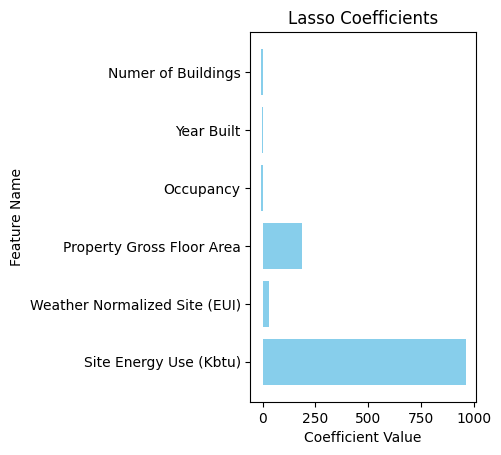

In [ ]:
coefficients = lasso001.coef_   

print(f"Linear Regression Coefficients (scikit-learn): {coefficients}")


import matplotlib.pyplot as plt
feature_names = X_train.columns 

# 2nd Model) Lasso-scaled
plt.subplot(1, 2, 2)

# Create a bar plot to visualize the coefficients
plt.barh(feature_names, coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Lasso Coefficients')
plt.gca().invert_yaxis()  # Invert the y-axis to display features from top to bottom